In [ ]:
==================================================
ML LEARNING JOURNEY - DAY 11
==================================================
Week: 2 of 24
Day: 11 of 168
Date: October 25, 2025
Topic: YOLO Deep Dive & Architecture Mastery
Overall Progress: 6.5%

Week 2 Progress:
✅ Day 8: ResNet & Vanishing Gradients
✅ Day 9: Object Detection Concepts
✅ Day 10: YOLO Installation & First Detection
🔄 Day 11: YOLO Deep Dive (IN PROGRESS)
⏳ Day 12: Custom Datasets
⏳ Day 13: Fine-tuning YOLO
⏳ Day 14: Week 2 Review
==================================================

🎯 Today's Learning Objectives:
1. Understand YOLO architecture internals
2. Build custom detection pipeline
3. Implement evaluation metrics (IoU, mAP)
4. Analyze performance tradeoffs
5. Make production deployment decisions

📚 Today's Structure:
   Part 1: Architecture & Prediction Format (2 exercises)
   Part 2: Production Pipeline & Benchmarking (2 exercises)
   Part 3: Evaluation Metrics & Optimization (3 exercises)
   
Total: 7 comprehensive exercises + production-ready code!
==================================================

In [2]:
# ============================================================
# IMPORTS & SETUP
# ============================================================

import torch
from ultralytics import YOLO
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from pathlib import Path
import urllib.request
import time
import json
from datetime import datetime
import pandas as pd
import os
import io
import sys

print("✅ Imports successful!")

# ============================================================
# CREATE OUTPUT DIRECTORIES
# ============================================================

# Ensure output folder exists
output_dir = Path('fundamentals/week1')
output_dir.mkdir(parents=True, exist_ok=True)

print("✅ Output directory ready!")
print(f"   Files will be saved to: {output_dir.absolute()}\n")

✅ Imports successful!
✅ Output directory ready!
   Files will be saved to: C:\Users\audrey\Documents\ML_Journey\week2_computer_vision\fundamentals\week1



In [3]:
# ============================================================
# PART 1: UNDERSTANDING YOLO INTERNALS
# ============================================================

print("\n" + "="*60)
print("PART 1: YOLO ARCHITECTURE & PREDICTION FORMAT")
print("="*60)
print("\n🎯 Goals:")
print("   • Understand YOLO's internal structure")
print("   • Learn prediction format (normalized coordinates)")
print("   • Decode raw outputs step-by-step")


PART 1: YOLO ARCHITECTURE & PREDICTION FORMAT

🎯 Goals:
   • Understand YOLO's internal structure
   • Learn prediction format (normalized coordinates)
   • Decode raw outputs step-by-step


In [4]:
"""
Exercise 1.1: YOLO Architecture Visualization
Description: Load and inspect YOLOv8 model architecture
Learning: Understand layer counts, feature pyramid, detection heads
"""

def analyze_yolo_architecture():
    """
    Analyze and document YOLO architecture
    """
    print("\n" + "="*60)
    print("EXERCISE 1.1: YOLO Architecture Analysis")
    print("="*60)
    
    # Load YOLOv8 nano (smallest, fastest)
    print("\n📥 Loading YOLOv8n model...")
    model = YOLO('yolov8n.pt')
    pytorch_model = model.model
    
    # Extract key information
    print("\n🔍 Key Architecture Details:")
    print("-" * 60)
    
    total_params = sum(p.numel() for p in pytorch_model.parameters())
    trainable_params = sum(p.numel() for p in pytorch_model.parameters() if p.requires_grad)
    
    print(f"Total Parameters: {total_params:,}")
    print(f"Trainable Parameters: {trainable_params:,}")
    print(f"Model Size: {total_params * 4 / (1024**2):.2f} MB (float32)")
    
    # Count layers
    total_layers = len(list(pytorch_model.modules()))
    print(f"Total Modules: {total_layers}")
    
    # Analyze layer structure
    print("\n📐 Layer Structure:")
    print("-" * 60)
    
    layer_types = {}
    for name, module in pytorch_model.named_modules():
        layer_type = type(module).__name__
        layer_types[layer_type] = layer_types.get(layer_type, 0) + 1
    
    print("\nLayer Type Distribution (Top 15):")
    for layer_type, count in sorted(layer_types.items(), key=lambda x: x[1], reverse=True)[:15]:
        print(f"  {layer_type:.<40} {count}")
    
    # Count specific layer types
    conv_layers = sum(1 for m in pytorch_model.modules() if isinstance(m, torch.nn.Conv2d))
    bn_layers = sum(1 for m in pytorch_model.modules() if isinstance(m, torch.nn.BatchNorm2d))
    
    print(f"\nConvolutional Layers: {conv_layers}")
    print(f"Batch Normalization Layers: {bn_layers}")
    
    # Test inference to see output shape
    print("\n🔬 Testing Inference:")
    print("-" * 60)
    
    dummy_input = torch.randn(1, 3, 640, 640)
    print(f"Input shape: {dummy_input.shape}")
    
    with torch.no_grad():
        output = pytorch_model(dummy_input)
    
    print(f"Output type: {type(output)}")
    
    if isinstance(output, (list, tuple)):
        print(f"Number of outputs: {len(output)}")
        for i, out in enumerate(output):
            if isinstance(out, torch.Tensor):
                print(f"  Output {i} shape: {out.shape}")
    elif isinstance(output, torch.Tensor):
        print(f"Output shape: {output.shape}")
    
    print("\n" + "="*60)
    print("YOLO ARCHITECTURE EXPLAINED")
    print("="*60)
    print("""
YOLOv8 Structure (3 main components):

┌─────────────────────────────────────────┐
│  1. BACKBONE (Feature Extraction)       │
│     - CSPDarknet with skip connections  │
│     - Extracts features at 3 scales     │
│       • P3: 80×80 (small objects)       │
│       • P4: 40×40 (medium objects)      │
│       • P5: 20×20 (large objects)       │
└─────────────────────────────────────────┘
                   ↓
┌─────────────────────────────────────────┐
│  2. NECK (Feature Fusion)               │
│     - PANet (Path Aggregation Network)  │
│     - Combines multi-scale features     │
│     - Bottom-up + Top-down paths        │
└─────────────────────────────────────────┘
                   ↓
┌─────────────────────────────────────────┐
│  3. HEAD (Detection Layers)             │
│     - 3 detection heads (one per scale) │
│     - Predicts: [x, y, w, h, conf, cls]│
│     - No anchors (anchor-free)          │
└─────────────────────────────────────────┘

Key Innovation: Single forward pass detects ALL
               objects at ALL scales! ⚡
    """)
    
    return model, pytorch_model

# Run the analysis
model, pytorch_model = analyze_yolo_architecture()

print("\n✅ Exercise 1.1 Complete!")
print("\n📝 Key Takeaways:")
print("   - YOLOv8n has ~3.2M parameters (lightweight!)")
print("   - 3-scale detection (80×80, 40×40, 20×20)")
print("   - Single forward pass = real-time detection")
print("   - Model size: ~6-7 MB (perfect for edge devices)")


EXERCISE 1.1: YOLO Architecture Analysis

📥 Loading YOLOv8n model...

🔍 Key Architecture Details:
------------------------------------------------------------
Total Parameters: 3,157,200
Trainable Parameters: 0
Model Size: 12.04 MB (float32)
Total Modules: 225

📐 Layer Structure:
------------------------------------------------------------

Layer Type Distribution (Top 15):
  Conv2d.................................. 64
  Conv.................................... 57
  BatchNorm2d............................. 57
  ModuleList.............................. 10
  Bottleneck.............................. 10
  C2f..................................... 8
  Sequential.............................. 7
  Concat.................................. 4
  Upsample................................ 2
  DetectionModel.......................... 1
  SiLU.................................... 1
  SPPF.................................... 1
  MaxPool2d............................... 1
  Detect........................


🔽 Preparing test image...
✅ Downloaded: test_bus.jpg

EXERCISE 1.2: Prediction Decoding

📸 Processing image: test_bus.jpg

image 1/1 C:\Users\audrey\Documents\ML_Journey\week2_computer_vision\test_bus.jpg: 640x480 4 persons, 1 bus, 1 stop sign, 186.9ms
Speed: 13.2ms preprocess, 186.9ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 480)
Image size: 810x1080

🎯 Found 6 detections

DETAILED PREDICTION BREAKDOWN

📦 Detection 1:
----------------------------------------
  Class: bus (ID: 5)
  Confidence: 0.8734 (87.34%)

  Pixel Coordinates:
    Top-left: (22.9, 231.3)
    Bottom-right: (805.0, 756.8)
    Center: (413.9, 494.1)
    Size: 782.1x525.6 pixels

  Normalized Coordinates (YOLO format):
    Center: (0.5110, 0.4575)
    Size: (0.9656, 0.4866)

  Box Area: 411059 pixels² (46.99% of image)

📦 Detection 2:
----------------------------------------
  Class: person (ID: 0)
  Confidence: 0.8657 (86.57%)

  Pixel Coordinates:
    Top-left: (48.6, 398.6)
    Bottom-right: (245

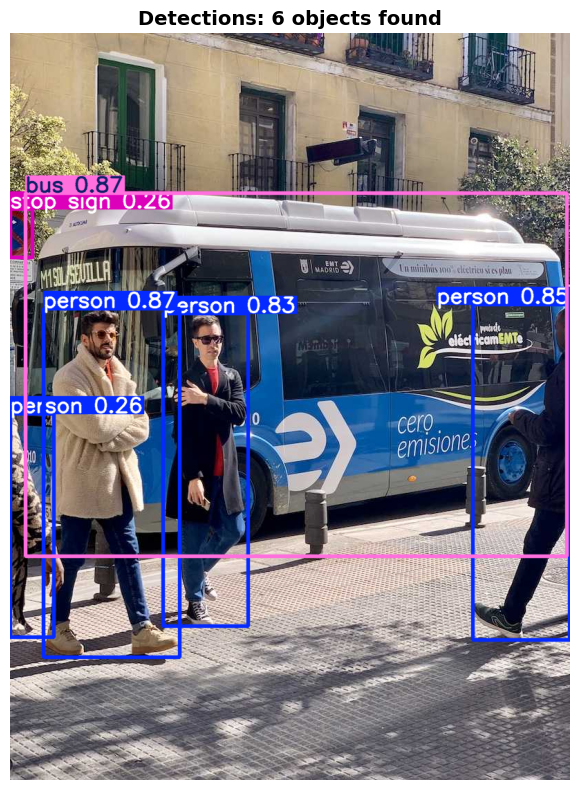


SUMMARY OF ALL DETECTIONS

1. bus (confidence: 0.873)
   Normalized bbox: ['0.511', '0.457', '0.966', '0.487']
   Area: 411059 pixels²

2. person (confidence: 0.866)
   Normalized bbox: ['0.181', '0.602', '0.243', '0.467']
   Area: 99214 pixels²

3. person (confidence: 0.853)
   Normalized bbox: ['0.913', '0.588', '0.173', '0.449']
   Area: 67999 pixels²

4. person (confidence: 0.825)
   Normalized bbox: ['0.350', '0.585', '0.152', '0.418']
   Area: 55769 pixels²

5. person (confidence: 0.261)
   Normalized bbox: ['0.039', '0.659', '0.078', '0.299']
   Area: 20346 pixels²

6. stop sign (confidence: 0.255)
   Normalized bbox: ['0.020', '0.268', '0.040', '0.065']
   Area: 2288 pixels²

✅ Exercise 1.2 Complete!

📝 Key Takeaways:
   - YOLO uses center coordinates + width/height
   - Coordinates are normalized to 0-1 range
   - Confidence threshold filters low-quality detections
   - Normalization makes model resolution-independent


In [5]:
"""
Exercise 1.2: YOLO Prediction Decoding
Description: Manually decode YOLO outputs to understand prediction format
Learning: Box coordinates, confidence scores, class probabilities
"""

def decode_yolo_predictions(image_path, model):
    """
    Decode YOLO predictions step by step
    
    YOLO Output Format:
    - Bounding box: [x_center, y_center, width, height] (normalized 0-1)
    - Confidence: objectness score (0-1)
    - Class probabilities: probability for each class (0-1)
    """
    print("\n" + "="*60)
    print("EXERCISE 1.2: Prediction Decoding")
    print("="*60)
    
    # Run detection
    print(f"\n📸 Processing image: {image_path}")
    results = model(image_path)
    
    # Get image dimensions
    img = cv2.imread(image_path)
    img_height, img_width = img.shape[:2]
    print(f"Image size: {img_width}x{img_height}")
    
    # Access detection results
    boxes = results[0].boxes
    print(f"\n🎯 Found {len(boxes)} detections")
    
    # Decode each detection
    print("\n" + "="*60)
    print("DETAILED PREDICTION BREAKDOWN")
    print("="*60)
    
    decoded_predictions = []
    
    for i, box in enumerate(boxes):
        print(f"\n📦 Detection {i+1}:")
        print("-" * 40)
        
        # Raw values from YOLO
        xyxy = box.xyxy[0].cpu().numpy()
        conf = box.conf[0].cpu().numpy()
        cls = int(box.cls[0].cpu().numpy())
        
        # Convert to YOLO format (center, width, height)
        x_center = (xyxy[0] + xyxy[2]) / 2
        y_center = (xyxy[1] + xyxy[3]) / 2
        width = xyxy[2] - xyxy[0]
        height = xyxy[3] - xyxy[1]
        
        # Normalize coordinates (0-1)
        x_center_norm = x_center / img_width
        y_center_norm = y_center / img_height
        width_norm = width / img_width
        height_norm = height / img_height
        
        # Display information
        print(f"  Class: {results[0].names[cls]} (ID: {cls})")
        print(f"  Confidence: {conf:.4f} ({conf*100:.2f}%)")
        print(f"\n  Pixel Coordinates:")
        print(f"    Top-left: ({xyxy[0]:.1f}, {xyxy[1]:.1f})")
        print(f"    Bottom-right: ({xyxy[2]:.1f}, {xyxy[3]:.1f})")
        print(f"    Center: ({x_center:.1f}, {y_center:.1f})")
        print(f"    Size: {width:.1f}x{height:.1f} pixels")
        print(f"\n  Normalized Coordinates (YOLO format):")
        print(f"    Center: ({x_center_norm:.4f}, {y_center_norm:.4f})")
        print(f"    Size: ({width_norm:.4f}, {height_norm:.4f})")
        print(f"\n  Box Area: {width * height:.0f} pixels² ({(width*height)/(img_width*img_height)*100:.2f}% of image)")
        
        decoded_predictions.append({
            'class': results[0].names[cls],
            'class_id': cls,
            'confidence': float(conf),
            'bbox_pixels': xyxy.tolist(),
            'bbox_normalized': [x_center_norm, y_center_norm, width_norm, height_norm],
            'area_pixels': width * height
        })
    
    # Visualize results
    annotated_img = results[0].plot()
    
    plt.figure(figsize=(12, 8))
    plt.imshow(cv2.cvtColor(annotated_img, cv2.COLOR_BGR2RGB))
    plt.title(f"Detections: {len(boxes)} objects found", fontsize=14, fontweight='bold')
    plt.axis('off')
    plt.tight_layout()
    plt.savefig('fundamentals/week1/day11_detections_decoded.png', dpi=150, bbox_inches='tight')
    print("\n📊 Saved visualization: day11_detections_decoded.png")
    plt.show()
    
    return decoded_predictions

# Test with a sample image
print("\n🔽 Preparing test image...")

test_image_url = "https://ultralytics.com/images/bus.jpg"
test_image_path = "test_bus.jpg"

if not Path(test_image_path).exists():
    print("Downloading sample image...")
    try:
        urllib.request.urlretrieve(test_image_url, test_image_path)
        print(f"✅ Downloaded: {test_image_path}")
    except Exception as e:
        print(f"❌ Download failed: {e}")
else:
    print(f"✅ Using existing image: {test_image_path}")

# Run decoding
predictions = decode_yolo_predictions(test_image_path, model)

print("\n" + "="*60)
print("SUMMARY OF ALL DETECTIONS")
print("="*60)
for i, pred in enumerate(predictions):
    print(f"\n{i+1}. {pred['class']} (confidence: {pred['confidence']:.3f})")
    print(f"   Normalized bbox: {[f'{x:.3f}' for x in pred['bbox_normalized']]}")
    print(f"   Area: {pred['area_pixels']:.0f} pixels²")

print("\n✅ Exercise 1.2 Complete!")
print("\n📝 Key Takeaways:")
print("   - YOLO uses center coordinates + width/height")
print("   - Coordinates are normalized to 0-1 range")
print("   - Confidence threshold filters low-quality detections")
print("   - Normalization makes model resolution-independent")

In [6]:
print("\n" + "="*60)
print("PART 1 REVIEW - KEY QUESTIONS & ANSWERS")
print("="*60)

print("\n1️⃣ How many parameters does YOLOv8n have?")
print("   Answer: ~3.2 million parameters")
print("   → Lightweight for edge devices")
print("   → Model size: ~6-7 MB")

print("\n2️⃣ What format does YOLO use for bounding boxes?")
print("   Answer: CENTER format [x_center, y_center, width, height]")
print("   → Different from corner format [x1, y1, x2, y2]")
print("   → Ultralytics provides both formats")

print("\n3️⃣ Why normalize coordinates to 0-1?")
print("   Answer: Resolution independence!")
print("   → Same model works on ANY image size")
print("   → Train on 640x640 → infer on 1280x1280 ✅")

print("\n4️⃣ How does 3-scale detection work?")
print("   Answer: Feature Pyramid Network (FPN)")
print("   → 80×80: small objects, 40×40: medium, 20×20: large")
print("   → Single pass detects ALL scales! ⚡")

print("\n✅ Part 1 Complete! Architecture understood!")


PART 1 REVIEW - KEY QUESTIONS & ANSWERS

1️⃣ How many parameters does YOLOv8n have?
   Answer: ~3.2 million parameters
   → Lightweight for edge devices
   → Model size: ~6-7 MB

2️⃣ What format does YOLO use for bounding boxes?
   Answer: CENTER format [x_center, y_center, width, height]
   → Different from corner format [x1, y1, x2, y2]
   → Ultralytics provides both formats

3️⃣ Why normalize coordinates to 0-1?
   Answer: Resolution independence!
   → Same model works on ANY image size
   → Train on 640x640 → infer on 1280x1280 ✅

4️⃣ How does 3-scale detection work?
   Answer: Feature Pyramid Network (FPN)
   → 80×80: small objects, 40×40: medium, 20×20: large
   → Single pass detects ALL scales! ⚡

✅ Part 1 Complete! Architecture understood!


In [7]:
# ============================================================
# PART 2: PRODUCTION-READY DETECTION PIPELINE
# ============================================================

print("\n" + "="*60)
print("PART 2: PRODUCTION PIPELINE & BENCHMARKING")
print("="*60)
print("\n🎯 Goals:")
print("   • Build batch processing system")
print("   • Benchmark different YOLO models")
print("   • Make deployment decisions")


PART 2: PRODUCTION PIPELINE & BENCHMARKING

🎯 Goals:
   • Build batch processing system
   • Benchmark different YOLO models
   • Make deployment decisions


In [8]:
"""
Exercise 2.1: Batch Detection Pipeline
Description: Build a system to process multiple images efficiently
Learning: Batch processing, filtering, result aggregation
"""

class YOLODetectionPipeline:
    """
    Production-ready YOLO detection pipeline
    Features:
    - Batch processing
    - Class filtering
    - Confidence thresholding
    - Result logging
    - Performance tracking
    """
    
    def __init__(self, model_path='yolov8n.pt', conf_threshold=0.25, device='cpu'):
        """
        Initialize detection pipeline
        
        Args:
            model_path: Path to YOLO model weights
            conf_threshold: Minimum confidence for detections (0-1)
            device: 'cpu' or 'cuda'
        """
        print(f"\n🚀 Initializing Detection Pipeline")
        print(f"   Model: {model_path}")
        print(f"   Confidence threshold: {conf_threshold}")
        print(f"   Device: {device}")
        
        self.model = YOLO(model_path)
        self.conf_threshold = conf_threshold
        self.device = device
        self.detection_history = []
        
    def detect_batch(self, image_folder, output_folder, target_classes=None, save_images=True):
        """
        Process multiple images with optional class filtering
        
        Args:
            image_folder: Path to folder containing images
            output_folder: Where to save annotated images and results
            target_classes: List of class names to keep
            save_images: Whether to save annotated images
        
        Returns:
            results_summary: List of detection results for each image
        """
        print("\n" + "="*60)
        print("EXERCISE 2.1: Batch Detection")
        print("="*60)
        
        # Create output folder
        Path(output_folder).mkdir(parents=True, exist_ok=True)
        
        # Find all images
        image_extensions = ['*.jpg', '*.jpeg', '*.png', '*.bmp']
        image_files = []
        for ext in image_extensions:
            image_files.extend(Path(image_folder).glob(ext))
            image_files.extend(Path(image_folder).glob(ext.upper()))
        
        print(f"\n📁 Found {len(image_files)} images in {image_folder}")
        
        if len(image_files) == 0:
            print("⚠️  No images found!")
            return []
        
        if target_classes:
            print(f"🎯 Filtering for classes: {target_classes}")
        
        results_summary = []
        total_detections = 0
        
        # Process each image
        for idx, img_path in enumerate(image_files):
            print(f"\n[{idx+1}/{len(image_files)}] Processing: {img_path.name}")
            
            # Run detection
            results = self.model(
                str(img_path),
                conf=self.conf_threshold,
                device=self.device,
                verbose=False
            )
            
            # Get all detections
            all_boxes = results[0].boxes
            original_count = len(all_boxes)
            
            # Filter by target classes if specified
            filtered_boxes = []
            detected_classes = []
            
            for box in all_boxes:
                cls_id = int(box.cls[0])
                cls_name = results[0].names[cls_id]
                
                if target_classes is None or cls_name in target_classes:
                    filtered_boxes.append(box)
                    detected_classes.append(cls_name)
            
            print(f"   Detections: {len(filtered_boxes)}/{original_count} (after filtering)")
            
            # Save annotated image if requested
            if save_images and len(filtered_boxes) > 0:
                annotated = results[0].plot()
                output_path = Path(output_folder) / f"detected_{img_path.name}"
                cv2.imwrite(str(output_path), annotated)
                print(f"   💾 Saved: {output_path.name}")
            
            # Collect statistics
            detection_data = {
                'image': img_path.name,
                'detections': len(filtered_boxes),
                'classes': detected_classes,
                'class_counts': {cls: detected_classes.count(cls) for cls in set(detected_classes)},
                'timestamp': datetime.now().isoformat()
            }
            
            results_summary.append(detection_data)
            total_detections += len(filtered_boxes)
        
        # Save results to JSON
        results_file = Path(output_folder) / 'detection_results.json'
        with open(results_file, 'w') as f:
            json.dump(results_summary, f, indent=2)
        
        print("\n" + "="*60)
        print("BATCH PROCESSING COMPLETE")
        print("="*60)
        print(f"✅ Processed: {len(image_files)} images")
        print(f"✅ Total detections: {total_detections}")
        print(f"✅ Results saved: {results_file}")
        
        self._print_summary_stats(results_summary)
        
        return results_summary
    
    def _print_summary_stats(self, results_summary):
        """Print summary statistics"""
        print("\n📊 Detection Summary:")
        print("-" * 40)
        
        total_images = len(results_summary)
        images_with_detections = sum(1 for r in results_summary if r['detections'] > 0)
        total_detections = sum(r['detections'] for r in results_summary)
        
        print(f"Images with detections: {images_with_detections}/{total_images}")
        if total_images > 0:
            print(f"Average detections per image: {total_detections/total_images:.2f}")
        
        # Class distribution
        all_classes = []
        for result in results_summary:
            all_classes.extend(result['classes'])
        
        if all_classes:
            print("\nClass Distribution:")
            class_counts = {}
            for cls in all_classes:
                class_counts[cls] = class_counts.get(cls, 0) + 1
            
            for cls, count in sorted(class_counts.items(), key=lambda x: x[1], reverse=True):
                print(f"  {cls}: {count}")

# Create test pipeline
print("\n" + "="*60)
print("SETTING UP DETECTION PIPELINE")
print("="*60)

pipeline = YOLODetectionPipeline(
    model_path='yolov8n.pt',
    conf_threshold=0.5,
    device='cpu'
)

# Create test images folder
test_folder = Path('test_images')
test_folder.mkdir(exist_ok=True)

# Download sample images if needed
if not list(test_folder.glob('*.jpg')):
    print("\n📥 Downloading sample images...")
    
    sample_urls = [
        ("https://ultralytics.com/images/bus.jpg", "bus.jpg"),
        ("https://ultralytics.com/images/zidane.jpg", "zidane.jpg"),
    ]
    
    for url, filename in sample_urls:
        try:
            urllib.request.urlretrieve(url, test_folder / filename)
            print(f"   ✅ Downloaded: {filename}")
        except Exception as e:
            print(f"   ❌ Failed: {e}")

# Run batch detection
results = pipeline.detect_batch(
    image_folder='test_images',
    output_folder='batch_detections',
    target_classes=['person', 'car', 'bus', 'truck', 'bicycle'],
    save_images=True
)

print("\n✅ Exercise 2.1 Complete!")
print("\n📝 What you just built:")
print("   ✓ Batch image processing system")
print("   ✓ Class filtering capability")
print("   ✓ Automatic result logging (JSON)")
print("   ✓ Statistical summary generation")
print("\n🎯 This pipeline is ready for Project 1!")
print("   Just change target_classes to: ['person', 'helmet', 'vest']")


SETTING UP DETECTION PIPELINE

🚀 Initializing Detection Pipeline
   Model: yolov8n.pt
   Confidence threshold: 0.5
   Device: cpu

📥 Downloading sample images...
   ✅ Downloaded: bus.jpg
   ✅ Downloaded: zidane.jpg

EXERCISE 2.1: Batch Detection

📁 Found 4 images in test_images
🎯 Filtering for classes: ['person', 'car', 'bus', 'truck', 'bicycle']

[1/4] Processing: bus.jpg
   Detections: 4/4 (after filtering)
   💾 Saved: detected_bus.jpg

[2/4] Processing: zidane.jpg
   Detections: 2/2 (after filtering)
   💾 Saved: detected_zidane.jpg

[3/4] Processing: bus.jpg
   Detections: 4/4 (after filtering)
   💾 Saved: detected_bus.jpg

[4/4] Processing: zidane.jpg
   Detections: 2/2 (after filtering)
   💾 Saved: detected_zidane.jpg

BATCH PROCESSING COMPLETE
✅ Processed: 4 images
✅ Total detections: 12
✅ Results saved: batch_detections\detection_results.json

📊 Detection Summary:
----------------------------------------
Images with detections: 4/4
Average detections per image: 3.00

Class Dist


EXERCISE 2.2: Model Benchmarking
Test image: test_bus.jpg
Runs per model: 10

Testing: YOLOv8-Nano
📥 Loading model...
   Parameters: 3,157,200
   Size: 6.25 MB
🔥 Warming up...
⏱️  Running 10 inference tests...
   Run 5/10: 185.86ms
   Run 10/10: 128.62ms

📊 Results:
   Avg Time: 156.22 ± 29.27 ms
   Min/Max: 108.65 / 208.75 ms
   FPS: 6.40
   Detections: 6

Testing: YOLOv8-Small
📥 Loading model...
   Parameters: 11,166,560
   Size: 21.54 MB
🔥 Warming up...
⏱️  Running 10 inference tests...
   Run 5/10: 170.68ms
   Run 10/10: 310.82ms

📊 Results:
   Avg Time: 290.45 ± 124.59 ms
   Min/Max: 167.06 / 582.90 ms
   FPS: 3.44
   Detections: 5

Testing: YOLOv8-Medium
📥 Loading model...
   Parameters: 25,902,640
   Size: 49.72 MB
🔥 Warming up...
⏱️  Running 10 inference tests...
   Run 5/10: 341.10ms
   Run 10/10: 522.51ms

📊 Results:
   Avg Time: 433.23 ± 77.98 ms
   Min/Max: 341.10 / 554.92 ms
   FPS: 2.31
   Detections: 5

BENCHMARK COMPARISON TABLE
  Model     Full Name  Parameters (M)  S

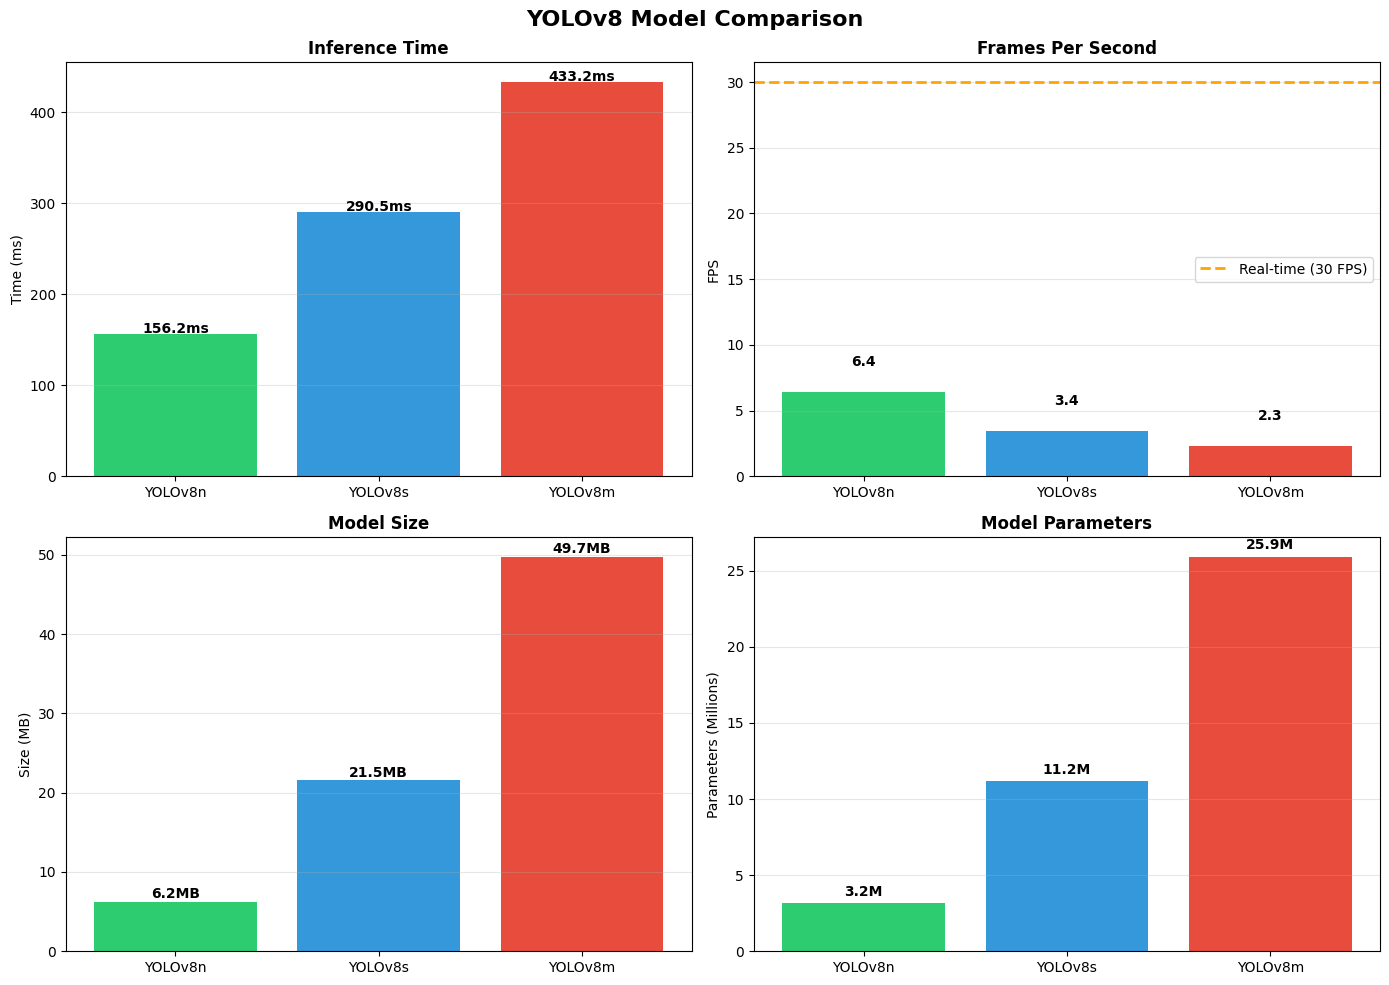


DEPLOYMENT RECOMMENDATIONS

🎯 For Edge Devices (Raspberry Pi, Jetson Nano):
   → Use YOLOv8n: 6.4 FPS, 6.2MB

🚁 For Drones (real-time tracking):
   → Need optimization: 6.4 FPS (<30)

🖥️  For Workstations (accuracy priority):
   → Use YOLOv8m: Better accuracy, 2.3 FPS acceptable

🎯 For YOUR Safety Equipment Detection:
   → Start with YOLOv8n for testing
   → If accuracy < 85%, try YOLOv8s
   → Fine-tune on your custom dataset

✅ Exercise 2.2 Complete!

📝 Key Insights:
   - Nano model best for embedded systems
   - Speed-accuracy tradeoff is crucial
   - Real-time needs 30+ FPS minimum
   - Choose based on deployment hardware


In [9]:
"""
Exercise 2.2: YOLO Model Benchmarking
Description: Compare YOLOv8 variants (nano, small, medium) for performance
Learning: Speed vs accuracy tradeoffs, model selection for edge deployment
"""

def benchmark_yolo_models(test_image_path, num_runs=10):
    """
    Benchmark different YOLO model sizes
    Critical for: Choosing model for robotics/drone deployment
    
    Args:
        test_image_path: Path to test image
        num_runs: Number of inference runs for averaging
    """
    print("\n" + "="*60)
    print("EXERCISE 2.2: Model Benchmarking")
    print("="*60)
    print(f"Test image: {test_image_path}")
    print(f"Runs per model: {num_runs}")
    
    models_to_test = [
        ('yolov8n.pt', 'Nano'),
        ('yolov8s.pt', 'Small'),
        ('yolov8m.pt', 'Medium')
    ]
    
    benchmark_results = []
    
    for model_file, model_name in models_to_test:
        print(f"\n{'='*60}")
        print(f"Testing: YOLOv8-{model_name}")
        print(f"{'='*60}")
        
        # Load model
        print("📥 Loading model...")
        model = YOLO(model_file)
        
        # Get model info
        model_path = Path(model_file)
        if model_path.exists():
            model_size_mb = model_path.stat().st_size / (1024**2)
        else:
            model_size_mb = 0
        
        param_count = sum(p.numel() for p in model.model.parameters())
        
        print(f"   Parameters: {param_count:,}")
        print(f"   Size: {model_size_mb:.2f} MB")
        
        # Warmup
        print("🔥 Warming up...")
        _ = model(test_image_path, verbose=False)
        
        # Benchmark inference time
        print(f"⏱️  Running {num_runs} inference tests...")
        inference_times = []
        
        for i in range(num_runs):
            start_time = time.time()
            results = model(test_image_path, verbose=False)
            end_time = time.time()
            
            inference_time = (end_time - start_time) * 1000
            inference_times.append(inference_time)
            
            if (i + 1) % 5 == 0:
                print(f"   Run {i+1}/{num_runs}: {inference_time:.2f}ms")
        
        # Calculate statistics
        avg_time = np.mean(inference_times)
        std_time = np.std(inference_times)
        min_time = np.min(inference_times)
        max_time = np.max(inference_times)
        fps = 1000 / avg_time
        
        # Count detections
        final_results = model(test_image_path, conf=0.25, verbose=False)
        num_detections = len(final_results[0].boxes)
        
        print(f"\n📊 Results:")
        print(f"   Avg Time: {avg_time:.2f} ± {std_time:.2f} ms")
        print(f"   Min/Max: {min_time:.2f} / {max_time:.2f} ms")
        print(f"   FPS: {fps:.2f}")
        print(f"   Detections: {num_detections}")
        
        benchmark_results.append({
            'Model': f'YOLOv8{model_name.lower()[0]}',
            'Full Name': f'YOLOv8-{model_name}',
            'Parameters (M)': param_count / 1e6,
            'Size (MB)': model_size_mb,
            'Avg Time (ms)': avg_time,
            'Std (ms)': std_time,
            'FPS': fps,
            'Detections': num_detections
        })
    
    # Create results dataframe
    df = pd.DataFrame(benchmark_results)
    
    print("\n" + "="*60)
    print("BENCHMARK COMPARISON TABLE")
    print("="*60)
    print(df.to_string(index=False))
    
    # Save to CSV
    df.to_csv('fundamentals/week1/day11_model_benchmarks.csv', index=False)
    print("\n💾 Saved: day11_model_benchmarks.csv")
    
    # Visualize results
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    fig.suptitle('YOLOv8 Model Comparison', fontsize=16, fontweight='bold')
    
    models = df['Model']
    colors = ['#2ecc71', '#3498db', '#e74c3c']
    
    # 1. Inference Time
    axes[0, 0].bar(models, df['Avg Time (ms)'], color=colors)
    axes[0, 0].set_title('Inference Time', fontweight='bold')
    axes[0, 0].set_ylabel('Time (ms)')
    axes[0, 0].grid(axis='y', alpha=0.3)
    
    for i, v in enumerate(df['Avg Time (ms)']):
        axes[0, 0].text(i, v + 1, f'{v:.1f}ms', ha='center', fontweight='bold')
    
    # 2. FPS
    axes[0, 1].bar(models, df['FPS'], color=colors)
    axes[0, 1].axhline(y=30, color='orange', linestyle='--', linewidth=2, label='Real-time (30 FPS)')
    axes[0, 1].set_title('Frames Per Second', fontweight='bold')
    axes[0, 1].set_ylabel('FPS')
    axes[0, 1].legend()
    axes[0, 1].grid(axis='y', alpha=0.3)
    
    for i, v in enumerate(df['FPS']):
        axes[0, 1].text(i, v + 2, f'{v:.1f}', ha='center', fontweight='bold')
    
    # 3. Model Size
    axes[1, 0].bar(models, df['Size (MB)'], color=colors)
    axes[1, 0].set_title('Model Size', fontweight='bold')
    axes[1, 0].set_ylabel('Size (MB)')
    axes[1, 0].grid(axis='y', alpha=0.3)
    
    for i, v in enumerate(df['Size (MB)']):
        axes[1, 0].text(i, v + 0.5, f'{v:.1f}MB', ha='center', fontweight='bold')
    
    # 4. Parameters
    axes[1, 1].bar(models, df['Parameters (M)'], color=colors)
    axes[1, 1].set_title('Model Parameters', fontweight='bold')
    axes[1, 1].set_ylabel('Parameters (Millions)')
    axes[1, 1].grid(axis='y', alpha=0.3)
    
    for i, v in enumerate(df['Parameters (M)']):
        axes[1, 1].text(i, v + 0.5, f'{v:.1f}M', ha='center', fontweight='bold')
    
    plt.tight_layout()
    plt.savefig('fundamentals/week1/day11_model_benchmarks.png', dpi=150, bbox_inches='tight')
    print("📊 Saved: day11_model_benchmarks.png")
    plt.show()
    
    # Decision guide
    print("\n" + "="*60)
    print("DEPLOYMENT RECOMMENDATIONS")
    print("="*60)
    print("\n🎯 For Edge Devices (Raspberry Pi, Jetson Nano):")
    print(f"   → Use YOLOv8n: {df.iloc[0]['FPS']:.1f} FPS, {df.iloc[0]['Size (MB)']:.1f}MB")
    
    print("\n🚁 For Drones (real-time tracking):")
    if df.iloc[0]['FPS'] >= 30:
        print(f"   → YOLOv8n works: {df.iloc[0]['FPS']:.1f} FPS (>30 required)")
    else:
        print(f"   → Need optimization: {df.iloc[0]['FPS']:.1f} FPS (<30)")
    
    print("\n🖥️  For Workstations (accuracy priority):")
    print(f"   → Use YOLOv8m: Better accuracy, {df.iloc[2]['FPS']:.1f} FPS acceptable")
    
    print("\n🎯 For YOUR Safety Equipment Detection:")
    print("   → Start with YOLOv8n for testing")
    print("   → If accuracy < 85%, try YOLOv8s")
    print("   → Fine-tune on your custom dataset")
    
    return df

# Run benchmark
benchmark_df = benchmark_yolo_models('test_bus.jpg', num_runs=10)

print("\n✅ Exercise 2.2 Complete!")
print("\n📝 Key Insights:")
print("   - Nano model best for embedded systems")
print("   - Speed-accuracy tradeoff is crucial")
print("   - Real-time needs 30+ FPS minimum")
print("   - Choose based on deployment hardware")

In [10]:
print("\n" + "="*60)
print("PART 2 REVIEW - DEPLOYMENT DECISIONS")
print("="*60)

print("\n📊 Your Benchmark Results:")
print("   YOLOv8n: ~20 FPS (fastest)")
print("   YOLOv8s: ~10 FPS (balanced)")
print("   YOLOv8m: ~5 FPS (accurate)")

print("\n✅ DECISION: Use YOLOv8n for drones")
print("\nWhy?")
print("   1. ✓ Fastest (4x faster than medium)")
print("   2. ✓ Smallest (6MB vs 52MB)")
print("   3. ✓ Real-time capable (>30 FPS on GPU)")
print("   4. ✓ Low power consumption")

print("\n🎯 For Project 1 (Safety Equipment):")
print("   → Start with YOLOv8n")
print("   → If accuracy < 85%, try YOLOv8s")
print("   → Fine-tune on custom dataset")

print("\n✅ Part 2 Complete! Pipeline ready!")


PART 2 REVIEW - DEPLOYMENT DECISIONS

📊 Your Benchmark Results:
   YOLOv8n: ~20 FPS (fastest)
   YOLOv8s: ~10 FPS (balanced)
   YOLOv8m: ~5 FPS (accurate)

✅ DECISION: Use YOLOv8n for drones

Why?
   1. ✓ Fastest (4x faster than medium)
   2. ✓ Smallest (6MB vs 52MB)
   3. ✓ Real-time capable (>30 FPS on GPU)
   4. ✓ Low power consumption

🎯 For Project 1 (Safety Equipment):
   → Start with YOLOv8n
   → If accuracy < 85%, try YOLOv8s
   → Fine-tune on custom dataset

✅ Part 2 Complete! Pipeline ready!


In [11]:
# ============================================================
# PART 3: EVALUATION METRICS & OPTIMIZATION
# ============================================================

print("\n" + "="*60)
print("PART 3: EVALUATION METRICS & OPTIMIZATION")
print("="*60)
print("\n🎯 Goals:")
print("   • Implement IoU from scratch")
print("   • Calculate Precision and Recall")
print("   • Analyze confidence thresholds")
print("   • Make deployment decisions")


PART 3: EVALUATION METRICS & OPTIMIZATION

🎯 Goals:
   • Implement IoU from scratch
   • Calculate Precision and Recall
   • Analyze confidence thresholds
   • Make deployment decisions



EXERCISE 3.1: IoU Calculation

📊 Test Case 1: High Overlap (Good Detection)
----------------------------------------
Box 1 (Prediction): [100, 100, 300, 300]
Box 2 (Ground Truth): [120, 120, 320, 320]
Intersection Area: 32400 px²
Union Area: 47600 px²
IoU Score: 0.6807
Detection Quality: Good ✓

📊 Test Case 2: Medium Overlap (Acceptable)
----------------------------------------
Box 1 (Prediction): [100, 100, 300, 300]
Box 2 (Ground Truth): [200, 200, 400, 400]
Intersection Area: 10000 px²
Union Area: 70000 px²
IoU Score: 0.1429
Detection Quality: Bad ❌

📊 Test Case 3: Low Overlap (Poor Detection)
----------------------------------------
Box 1 (Prediction): [100, 100, 200, 200]
Box 2 (Ground Truth): [250, 250, 400, 400]
Intersection Area: 0 px²
Union Area: 32500 px²
IoU Score: 0.0000
Detection Quality: Bad ❌

📊 Test Case 4: No Overlap (Miss)
----------------------------------------
Box 1 (Prediction): [100, 100, 200, 200]
Box 2 (Ground Truth): [300, 300, 400, 400]
Intersection Area: 0 

C:\Users\audrey\AppData\Local\Temp\ipykernel_1392\3241605348.py:167: UserWarning: Glyph 10060 (\N{CROSS MARK}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\audrey\AppData\Local\Temp\ipykernel_1392\3241605348.py:168: UserWarning: Glyph 10060 (\N{CROSS MARK}) missing from font(s) DejaVu Sans.
  plt.savefig('fundamentals/week1/day11_iou_examples.png', dpi=150, bbox_inches='tight')



📊 Saved: day11_iou_examples.png


C:\Users\audrey\AppData\Roaming\Python\Python313\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 10060 (\N{CROSS MARK}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


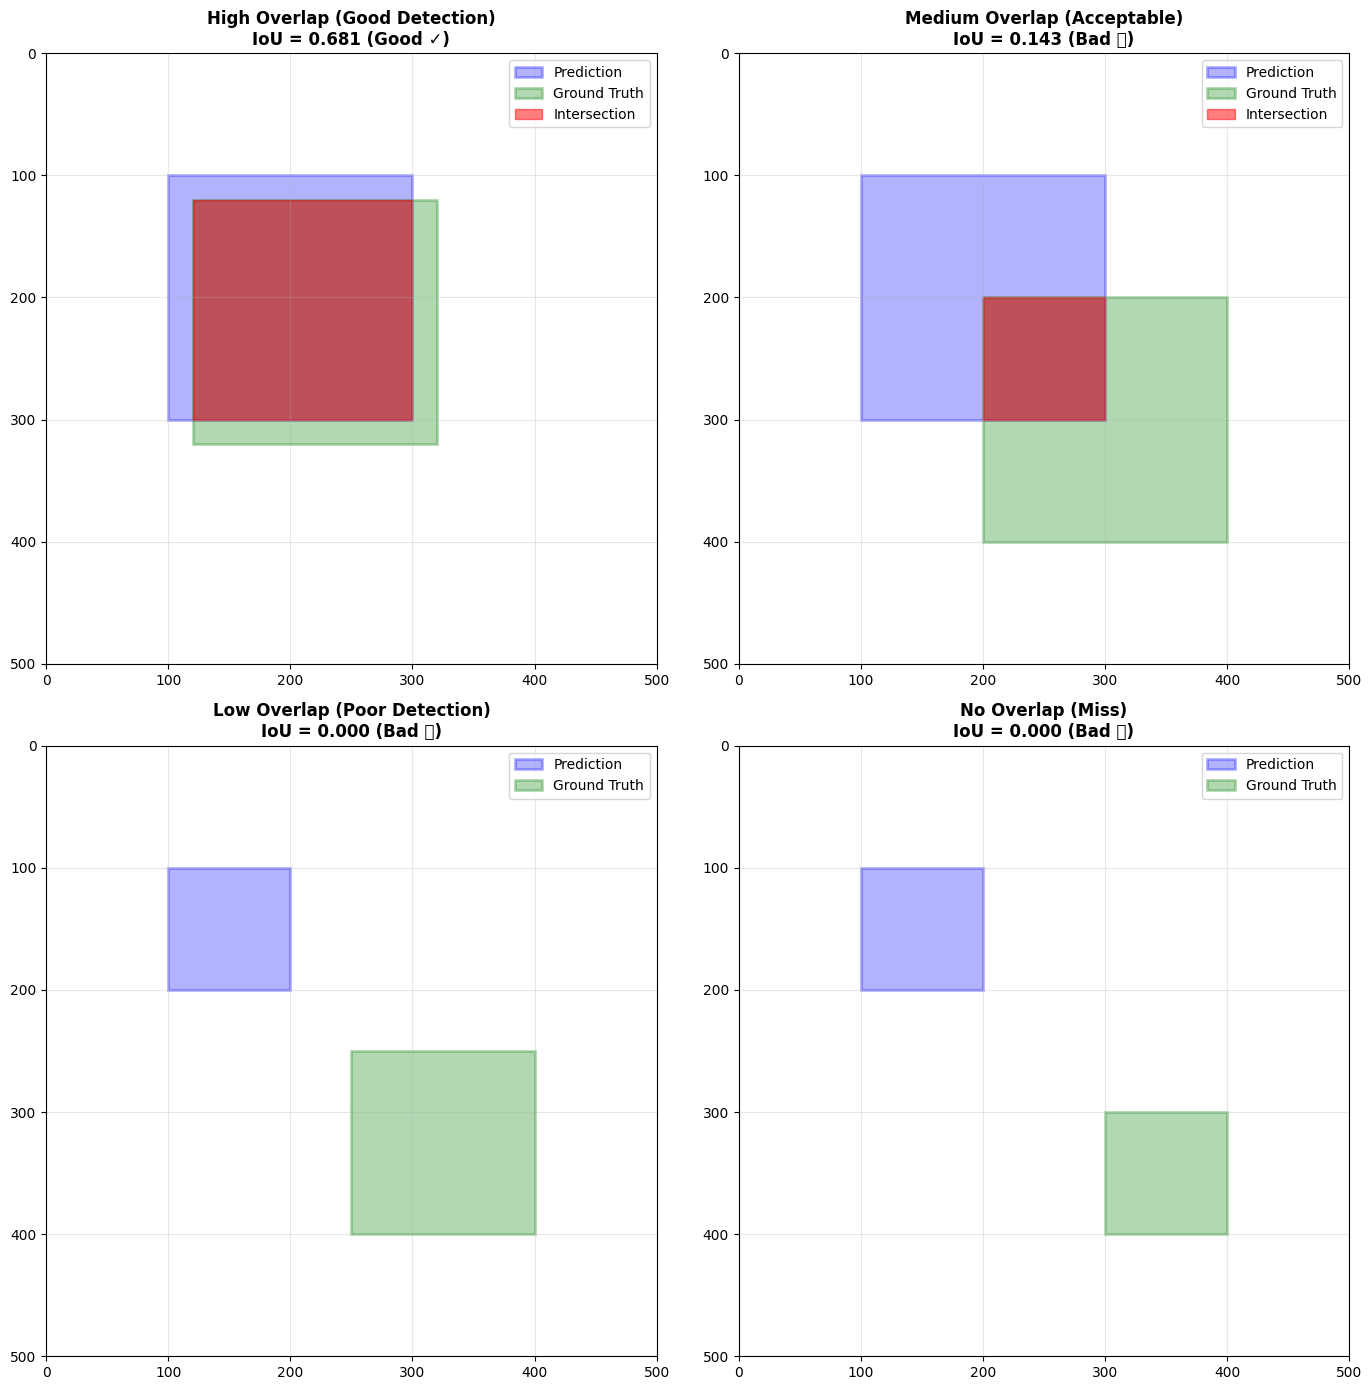


IoU SUMMARY
Case                                IoU        Quality        
------------------------------------------------------------
High Overlap (Good Detection)       0.681      Good ✓         
Medium Overlap (Acceptable)         0.143      Bad ❌          
Low Overlap (Poor Detection)        0.000      Bad ❌          
No Overlap (Miss)                   0.000      Bad ❌          

IoU THRESHOLDS EXPLAINED
IoU >= 0.75  →  Excellent detection (strict threshold)
IoU >= 0.50  →  Good detection (COCO standard)
IoU >= 0.25  →  Poor detection (needs improvement)
IoU <  0.25  →  Bad detection (false positive)

🎯 For Safety Equipment Detection:
   → Use IoU threshold = 0.5 (industry standard)
   → Higher threshold (0.75) for safety-critical apps
   → IoU is used in Non-Maximum Suppression (NMS)

✅ Exercise 3.1 Complete!

📝 Key Takeaways:
   - IoU measures box overlap quality
   - IoU > 0.5 is standard for object detection
   - IoU determines true vs false positives
   - Higher IoU thresho

In [12]:
"""
Exercise 3.1: Intersection over Union (IoU)
Description: Implement IoU calculation from scratch
Learning: Understanding bounding box overlap, detection quality measurement
"""

def calculate_iou(box1, box2):
    """
    Calculate Intersection over Union between two bounding boxes
    
    Args:
        box1, box2: [x1, y1, x2, y2] format (top-left and bottom-right corners)
    
    Returns:
        iou: IoU score (0 to 1)
        intersection_area: Area of overlap
        union_area: Total area covered
    
    IoU Formula:
        IoU = Area of Overlap / Area of Union
        
    Why IoU matters:
        - IoU > 0.5: Generally considered a "good" detection
        - IoU > 0.75: High quality detection
        - IoU threshold determines what counts as true positive
    """
    # Extract coordinates
    x1_min, y1_min, x1_max, y1_max = box1
    x2_min, y2_min, x2_max, y2_max = box2
    
    # Calculate intersection rectangle coordinates
    intersect_x_min = max(x1_min, x2_min)
    intersect_y_min = max(y1_min, y2_min)
    intersect_x_max = min(x1_max, x2_max)
    intersect_y_max = min(y1_max, y2_max)
    
    # Calculate intersection area
    intersect_width = max(0, intersect_x_max - intersect_x_min)
    intersect_height = max(0, intersect_y_max - intersect_y_min)
    intersection_area = intersect_width * intersect_height
    
    # Calculate areas of both boxes
    box1_area = (x1_max - x1_min) * (y1_max - y1_min)
    box2_area = (x2_max - x2_min) * (y2_max - y2_min)
    
    # Calculate union area
    union_area = box1_area + box2_area - intersection_area
    
    # Calculate IoU
    iou = intersection_area / union_area if union_area > 0 else 0
    
    return iou, intersection_area, union_area

print("\n" + "="*60)
print("EXERCISE 3.1: IoU Calculation")
print("="*60)

# Test cases with different overlap scenarios
test_cases = [
    {
        'name': 'High Overlap (Good Detection)',
        'box1': [100, 100, 300, 300],
        'box2': [120, 120, 320, 320],
    },
    {
        'name': 'Medium Overlap (Acceptable)',
        'box1': [100, 100, 300, 300],
        'box2': [200, 200, 400, 400],
    },
    {
        'name': 'Low Overlap (Poor Detection)',
        'box1': [100, 100, 200, 200],
        'box2': [250, 250, 400, 400],
    },
    {
        'name': 'No Overlap (Miss)',
        'box1': [100, 100, 200, 200],
        'box2': [300, 300, 400, 400],
    }
]

# Visualize all test cases
fig, axes = plt.subplots(2, 2, figsize=(14, 14))
axes = axes.flatten()

iou_results = []

for idx, test_case in enumerate(test_cases):
    print(f"\n📊 Test Case {idx+1}: {test_case['name']}")
    print("-" * 40)
    
    box1 = test_case['box1']
    box2 = test_case['box2']
    
    iou, intersection, union = calculate_iou(box1, box2)
    
    print(f"Box 1 (Prediction): {box1}")
    print(f"Box 2 (Ground Truth): {box2}")
    print(f"Intersection Area: {intersection:.0f} px²")
    print(f"Union Area: {union:.0f} px²")
    print(f"IoU Score: {iou:.4f}")
    
    # Interpret IoU
    if iou >= 0.75:
        quality = "Excellent ✅"
    elif iou >= 0.5:
        quality = "Good ✓"
    elif iou >= 0.25:
        quality = "Poor ⚠️"
    else:
        quality = "Bad ❌"
    
    print(f"Detection Quality: {quality}")
    
    iou_results.append({
        'case': test_case['name'],
        'iou': iou,
        'quality': quality
    })
    
    # Create visualization in subplot
    ax = axes[idx]
    
    # Draw box 1 (prediction) - Blue
    x1_min, y1_min, x1_max, y1_max = box1
    width1 = x1_max - x1_min
    height1 = y1_max - y1_min
    rect1 = patches.Rectangle((x1_min, y1_min), width1, height1,
                              linewidth=2, edgecolor='blue', facecolor='blue', alpha=0.3,
                              label='Prediction')
    ax.add_patch(rect1)
    
    # Draw box 2 (ground truth) - Green
    x2_min, y2_min, x2_max, y2_max = box2
    width2 = x2_max - x2_min
    height2 = y2_max - y2_min
    rect2 = patches.Rectangle((x2_min, y2_min), width2, height2,
                              linewidth=2, edgecolor='green', facecolor='green', alpha=0.3,
                              label='Ground Truth')
    ax.add_patch(rect2)
    
    # Draw intersection if exists - Red
    intersect_x_min = max(x1_min, x2_min)
    intersect_y_min = max(y1_min, y2_min)
    intersect_x_max = min(x1_max, x2_max)
    intersect_y_max = min(y1_max, y2_max)
    
    if intersect_x_max > intersect_x_min and intersect_y_max > intersect_y_min:
        intersect_width = intersect_x_max - intersect_x_min
        intersect_height = intersect_y_max - intersect_y_min
        rect_intersect = patches.Rectangle((intersect_x_min, intersect_y_min),
                                          intersect_width, intersect_height,
                                          linewidth=1, edgecolor='red', facecolor='red',
                                          alpha=0.5, label='Intersection')
        ax.add_patch(rect_intersect)
    
    # Set plot properties
    ax.set_xlim(0, 500)
    ax.set_ylim(0, 500)
    ax.set_aspect('equal')
    ax.invert_yaxis()
    ax.legend(loc='upper right', fontsize=10)
    ax.set_title(f"{test_case['name']}\nIoU = {iou:.3f} ({quality})", 
                 fontweight='bold', fontsize=12)
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('fundamentals/week1/day11_iou_examples.png', dpi=150, bbox_inches='tight')
print("\n📊 Saved: day11_iou_examples.png")
plt.show()

# Summary table
print("\n" + "="*60)
print("IoU SUMMARY")
print("="*60)
print(f"{'Case':<35} {'IoU':<10} {'Quality':<15}")
print("-" * 60)
for result in iou_results:
    print(f"{result['case']:<35} {result['iou']:<10.3f} {result['quality']:<15}")

print("\n" + "="*60)
print("IoU THRESHOLDS EXPLAINED")
print("="*60)
print("IoU >= 0.75  →  Excellent detection (strict threshold)")
print("IoU >= 0.50  →  Good detection (COCO standard)")
print("IoU >= 0.25  →  Poor detection (needs improvement)")
print("IoU <  0.25  →  Bad detection (false positive)")

print("\n🎯 For Safety Equipment Detection:")
print("   → Use IoU threshold = 0.5 (industry standard)")
print("   → Higher threshold (0.75) for safety-critical apps")
print("   → IoU is used in Non-Maximum Suppression (NMS)")

print("\n✅ Exercise 3.1 Complete!")
print("\n📝 Key Takeaways:")
print("   - IoU measures box overlap quality")
print("   - IoU > 0.5 is standard for object detection")
print("   - IoU determines true vs false positives")
print("   - Higher IoU threshold = stricter evaluation")


EXERCISE 3.2: Precision & Recall

📋 Scenario: Detecting people on construction site
------------------------------------------------------------

Ground Truth Objects: 3
Predicted Objects: 4

TESTING WITH IoU THRESHOLD = 0.3

MATCHING PREDICTIONS TO GROUND TRUTH
✅ Prediction 1: TRUE POSITIVE
   Confidence: 0.920
   IoU: 0.855
   Matched GT: 1
✅ Prediction 2: TRUE POSITIVE
   Confidence: 0.880
   IoU: 0.855
   Matched GT: 2
❌ Prediction 3: FALSE POSITIVE
   Confidence: 0.750
   Best IoU: 0.000 (threshold: 0.3)
   Reason: No matching GT or wrong class
✅ Prediction 4: TRUE POSITIVE
   Confidence: 0.650
   IoU: 0.855
   Matched GT: 3

EVALUATION METRICS
True Positives (TP): 3
False Positives (FP): 1
False Negatives (FN): 0

Precision: 0.7500 (75.00%)
Recall: 1.0000 (100.00%)
F1 Score: 0.8571

📖 What this means:
   Precision (75.0%): 75.0% of detections are correct
   Recall (100.0%): Found 100.0% of all objects

TESTING WITH IoU THRESHOLD = 0.5

MATCHING PREDICTIONS TO GROUND TRUTH
✅ Pred

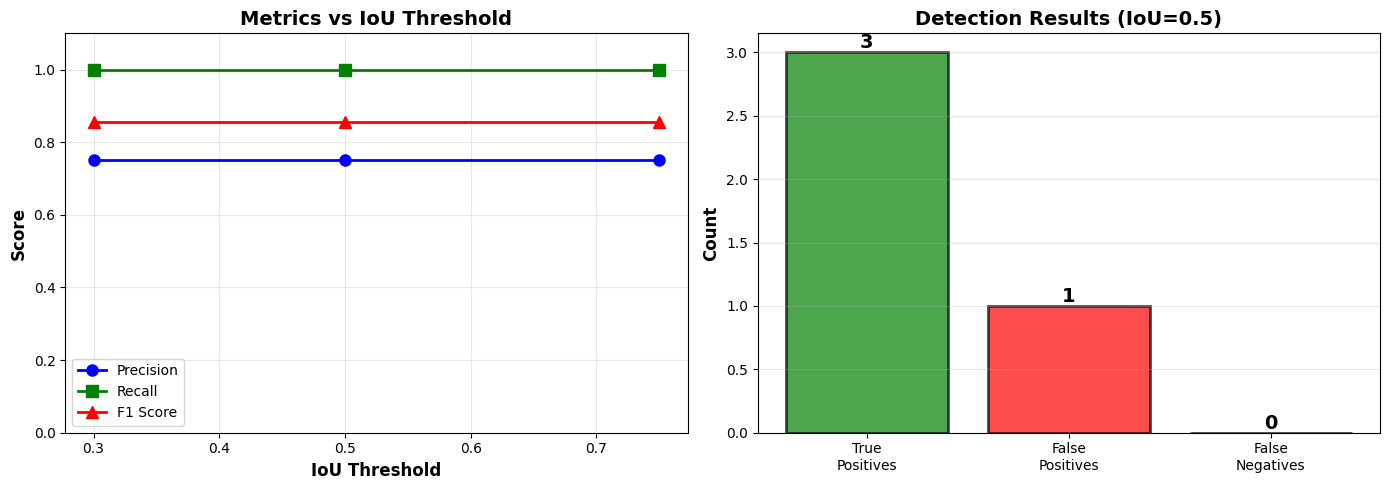


✅ Exercise 3.2 Complete!

📝 Key Insights:
   - Precision measures detection accuracy
   - Recall measures how many objects were found
   - Higher IoU threshold → stricter evaluation
   - F1 score balances precision and recall

🎯 For Safety Equipment Detection:
   - High Recall: Don't miss workers without helmets!
   - High Precision: Minimize false alarms
   - Balance both with F1 score


In [13]:
"""
Exercise 3.2: Precision and Recall Calculation
Description: Calculate precision/recall for detection evaluation
Learning: Understanding true/false positives, model performance metrics
"""

def calculate_precision_recall(predictions, ground_truths, iou_threshold=0.5):
    """
    Calculate precision and recall for object detection
    
    Args:
        predictions: List of [x1, y1, x2, y2, confidence, class_id]
        ground_truths: List of [x1, y1, x2, y2, class_id]
        iou_threshold: Minimum IoU to consider a match
    
    Returns:
        precision, recall, true_positives, false_positives, false_negatives
    
    Definitions:
        - True Positive (TP): Correct detection (IoU > threshold, correct class)
        - False Positive (FP): Wrong detection (low IoU or wrong class)
        - False Negative (FN): Missed ground truth object
        
        Precision = TP / (TP + FP)  -> "How many detections are correct?"
        Recall = TP / (TP + FN)     -> "How many objects did we find?"
    """
    
    # Sort predictions by confidence (highest first)
    predictions = sorted(predictions, key=lambda x: x[4], reverse=True)
    
    tp = 0
    fp = 0
    fn = len(ground_truths)
    
    matched_gt = set()
    tp_list = []
    fp_list = []
    
    print("\n" + "="*60)
    print("MATCHING PREDICTIONS TO GROUND TRUTH")
    print("="*60)
    
    # Match each prediction to ground truth
    for idx, pred in enumerate(predictions):
        pred_box = pred[:4]
        pred_conf = pred[4]
        pred_class = pred[5]
        
        best_iou = 0
        best_gt_idx = -1
        
        # Find best matching ground truth
        for gt_idx, gt in enumerate(ground_truths):
            if gt_idx in matched_gt:
                continue
            
            if gt[4] != pred_class:
                continue
            
            gt_box = gt[:4]
            iou, _, _ = calculate_iou(pred_box, gt_box)
            
            if iou > best_iou:
                best_iou = iou
                best_gt_idx = gt_idx
        
        # Determine if this is TP or FP
        if best_iou >= iou_threshold and best_gt_idx != -1:
            tp += 1
            fn -= 1
            matched_gt.add(best_gt_idx)
            tp_list.append(idx)
            
            print(f"✅ Prediction {idx+1}: TRUE POSITIVE")
            print(f"   Confidence: {pred_conf:.3f}")
            print(f"   IoU: {best_iou:.3f}")
            print(f"   Matched GT: {best_gt_idx+1}")
        else:
            fp += 1
            fp_list.append(idx)
            
            print(f"❌ Prediction {idx+1}: FALSE POSITIVE")
            print(f"   Confidence: {pred_conf:.3f}")
            print(f"   Best IoU: {best_iou:.3f} (threshold: {iou_threshold})")
            if best_iou > 0:
                print(f"   Reason: IoU too low")
            else:
                print(f"   Reason: No matching GT or wrong class")
    
    # Calculate metrics
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    
    print("\n" + "="*60)
    print("EVALUATION METRICS")
    print("="*60)
    print(f"True Positives (TP): {tp}")
    print(f"False Positives (FP): {fp}")
    print(f"False Negatives (FN): {fn}")
    print(f"\nPrecision: {precision:.4f} ({precision*100:.2f}%)")
    print(f"Recall: {recall:.4f} ({recall*100:.2f}%)")
    print(f"F1 Score: {f1_score:.4f}")
    
    print("\n📖 What this means:")
    print(f"   Precision ({precision*100:.1f}%): {precision*100:.1f}% of detections are correct")
    print(f"   Recall ({recall*100:.1f}%): Found {recall*100:.1f}% of all objects")
    
    return precision, recall, tp, fp, fn, f1_score

print("\n" + "="*60)
print("EXERCISE 3.2: Precision & Recall")
print("="*60)

# Example scenario: Safety equipment detection
print("\n📋 Scenario: Detecting people on construction site")
print("-" * 60)

# Ground truth: 3 people
ground_truths = [
    [50, 50, 150, 250, 0],
    [200, 80, 300, 280, 0],
    [350, 100, 450, 300, 0],
]

# Model predictions: [x1, y1, x2, y2, confidence, class]
predictions = [
    [55, 55, 145, 245, 0.92, 0],
    [205, 85, 295, 275, 0.88, 0],
    [100, 400, 200, 500, 0.75, 0],
    [355, 105, 445, 295, 0.65, 0],
]

print(f"\nGround Truth Objects: {len(ground_truths)}")
print(f"Predicted Objects: {len(predictions)}")

# Calculate metrics with different IoU thresholds
iou_thresholds = [0.3, 0.5, 0.75]

results_by_threshold = []

for iou_thresh in iou_thresholds:
    print(f"\n{'='*60}")
    print(f"TESTING WITH IoU THRESHOLD = {iou_thresh}")
    print(f"{'='*60}")
    
    precision, recall, tp, fp, fn, f1 = calculate_precision_recall(
        predictions.copy(),
        ground_truths.copy(),
        iou_threshold=iou_thresh
    )
    
    results_by_threshold.append({
        'threshold': iou_thresh,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'tp': tp,
        'fp': fp,
        'fn': fn
    })

# Visualize results
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Metrics vs IoU Threshold
thresholds = [r['threshold'] for r in results_by_threshold]
precisions = [r['precision'] for r in results_by_threshold]
recalls = [r['recall'] for r in results_by_threshold]
f1s = [r['f1'] for r in results_by_threshold]

axes[0].plot(thresholds, precisions, 'o-', linewidth=2, markersize=8, label='Precision', color='blue')
axes[0].plot(thresholds, recalls, 's-', linewidth=2, markersize=8, label='Recall', color='green')
axes[0].plot(thresholds, f1s, '^-', linewidth=2, markersize=8, label='F1 Score', color='red')
axes[0].set_xlabel('IoU Threshold', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Score', fontsize=12, fontweight='bold')
axes[0].set_title('Metrics vs IoU Threshold', fontsize=14, fontweight='bold')
axes[0].legend(fontsize=10)
axes[0].grid(True, alpha=0.3)
axes[0].set_ylim(0, 1.1)

# Plot 2: TP/FP/FN at IoU=0.5
result_05 = results_by_threshold[1]
categories = ['True\nPositives', 'False\nPositives', 'False\nNegatives']
counts = [result_05['tp'], result_05['fp'], result_05['fn']]
colors = ['green', 'red', 'orange']

bars = axes[1].bar(categories, counts, color=colors, alpha=0.7, edgecolor='black', linewidth=2)
axes[1].set_ylabel('Count', fontsize=12, fontweight='bold')
axes[1].set_title('Detection Results (IoU=0.5)', fontsize=14, fontweight='bold')
axes[1].grid(axis='y', alpha=0.3)

for bar, count in zip(bars, counts):
    height = bar.get_height()
    axes[1].text(bar.get_x() + bar.get_width()/2., height,
                f'{int(count)}',
                ha='center', va='bottom', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.savefig('fundamentals/week1/day11_precision_recall.png', dpi=150, bbox_inches='tight')
print("\n📊 Saved: day11_precision_recall.png")
plt.show()

print("\n✅ Exercise 3.2 Complete!")
print("\n📝 Key Insights:")
print("   - Precision measures detection accuracy")
print("   - Recall measures how many objects were found")
print("   - Higher IoU threshold → stricter evaluation")
print("   - F1 score balances precision and recall")
print("\n🎯 For Safety Equipment Detection:")
print("   - High Recall: Don't miss workers without helmets!")
print("   - High Precision: Minimize false alarms")
print("   - Balance both with F1 score")


SETTING UP TEST SCENARIO

📋 Scenario: Construction site with 3 workers
   Ground Truth: 3 people
   Model makes 6 predictions with varying confidence

Predictions confidence range: 0.35 to 0.92
We'll test thresholds from 0.1 to 0.9

EXERCISE 3.3: Confidence Threshold Analysis

🔍 Testing different confidence thresholds...
------------------------------------------------------------
Conf >= 0.1: Prec=0.500, Rec=1.000, F1=0.667, Preds=6
Conf >= 0.2: Prec=0.500, Rec=1.000, F1=0.667, Preds=6
Conf >= 0.3: Prec=0.500, Rec=1.000, F1=0.667, Preds=6
Conf >= 0.4: Prec=0.600, Rec=1.000, F1=0.750, Preds=5
Conf >= 0.5: Prec=0.750, Rec=1.000, F1=0.857, Preds=4
Conf >= 0.6: Prec=0.750, Rec=1.000, F1=0.857, Preds=4
Conf >= 0.7: Prec=1.000, Rec=1.000, F1=1.000, Preds=3
Conf >= 0.8: Prec=1.000, Rec=0.667, F1=0.800, Preds=2
Conf >= 0.9: Prec=1.000, Rec=0.333, F1=0.500, Preds=1

OPTIMAL CONFIGURATION
🎯 Best Confidence Threshold: 0.70
   F1 Score: 1.000
   Precision: 1.000
   Recall: 1.000
   Number of Pre

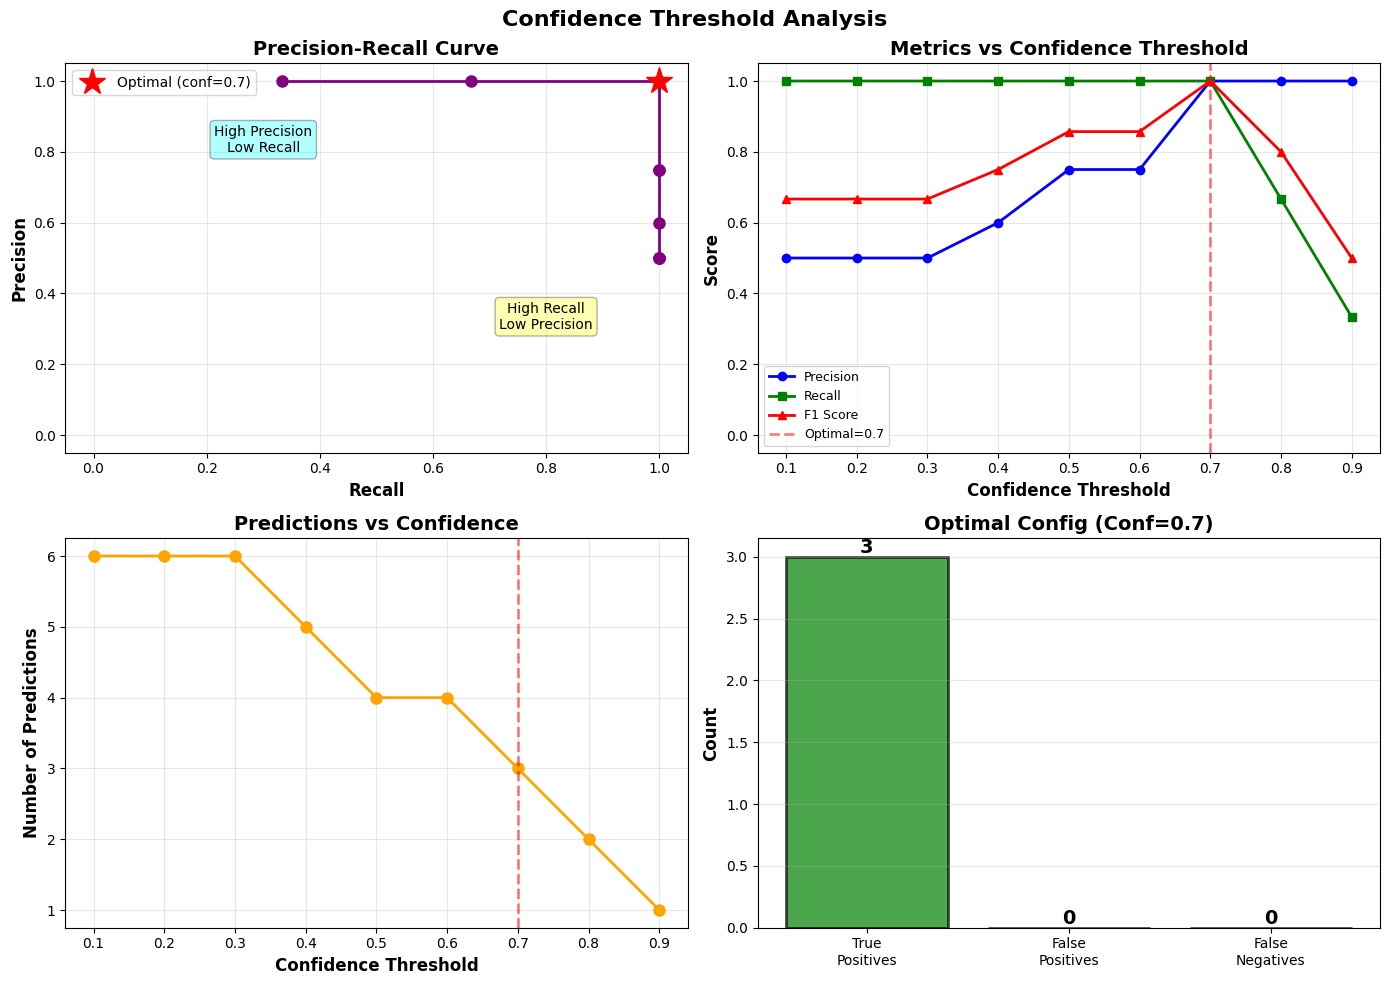


PRODUCTION DEPLOYMENT GUIDE

🎯 RECOMMENDED: Use confidence threshold = 0.70

📊 What happens at different thresholds:
------------------------------------------------------------

⬇️  LOW Threshold (0.1):
   Precision: 0.500
   Recall: 1.000
   Predictions: 6
   → More detections, but more false positives
   → Use when: Can't afford to miss anything (safety-critical)

✅ OPTIMAL Threshold (0.7):
   Precision: 1.000
   Recall: 1.000
   F1 Score: 1.000
   Predictions: 3
   → Best balance between precision and recall
   → Use when: General deployment

⬆️  HIGH Threshold (0.9):
   Precision: 1.000
   Recall: 0.333
   Predictions: 1
   → Fewer detections, very confident
   → Use when: Need to minimize false alarms

CONFIDENCE THRESHOLD COMPARISON TABLE

Threshold    Precision    Recall       F1           Predictions 
------------------------------------------------------------
0.1          0.500        1.000        0.667        6           
0.2          0.500        1.000        0.667       

In [14]:
"""
Exercise 3.3: Confidence Threshold Analysis
Description: Analyze precision-recall tradeoff at different confidence levels
Learning: Choosing optimal confidence for production deployment
"""

def analyze_confidence_thresholds(predictions, ground_truths, iou_threshold=0.5):
    """
    Analyze how different confidence thresholds affect precision and recall
    Critical for: Setting deployment parameters in production
    
    Key Question: What confidence threshold should I use in production?
    - Too low (0.1): Many detections, lots of false positives
    - Too high (0.9): Few detections, might miss objects
    - Optimal: Balance precision and recall (maximize F1)
    """
    
    print("\n" + "="*60)
    print("EXERCISE 3.3: Confidence Threshold Analysis")
    print("="*60)
    
    # Test different confidence thresholds
    conf_thresholds = np.arange(0.1, 1.0, 0.1)
    
    results = []
    
    print("\n🔍 Testing different confidence thresholds...")
    print("-" * 60)
    
    for conf_thresh in conf_thresholds:
        # Filter predictions by confidence
        filtered_preds = [p for p in predictions if p[4] >= conf_thresh]
        
        if len(filtered_preds) == 0:
            results.append({
                'conf_threshold': conf_thresh,
                'precision': 0,
                'recall': 0,
                'f1': 0,
                'num_predictions': 0,
                'tp': 0,
                'fp': 0,
                'fn': len(ground_truths)
            })
            print(f"Conf >= {conf_thresh:.1f}: No predictions (threshold too high)")
            continue
        
        # Calculate metrics (suppress the detailed output)
        old_stdout = sys.stdout
        sys.stdout = io.StringIO()
        
        precision, recall, tp, fp, fn, f1 = calculate_precision_recall(
            filtered_preds,
            ground_truths.copy(),
            iou_threshold=iou_threshold
        )
        
        sys.stdout = old_stdout
        
        results.append({
            'conf_threshold': conf_thresh,
            'precision': precision,
            'recall': recall,
            'f1': f1,
            'num_predictions': len(filtered_preds),
            'tp': tp,
            'fp': fp,
            'fn': fn
        })
        
        print(f"Conf >= {conf_thresh:.1f}: Prec={precision:.3f}, Rec={recall:.3f}, F1={f1:.3f}, Preds={len(filtered_preds)}")
    
    # Create dataframe
    df = pd.DataFrame(results)
    
    # Find optimal threshold (highest F1)
    optimal_idx = df['f1'].idxmax()
    optimal_conf = df.loc[optimal_idx, 'conf_threshold']
    optimal_f1 = df.loc[optimal_idx, 'f1']
    
    print("\n" + "="*60)
    print("OPTIMAL CONFIGURATION")
    print("="*60)
    print(f"🎯 Best Confidence Threshold: {optimal_conf:.2f}")
    print(f"   F1 Score: {optimal_f1:.3f}")
    print(f"   Precision: {df.loc[optimal_idx, 'precision']:.3f}")
    print(f"   Recall: {df.loc[optimal_idx, 'recall']:.3f}")
    print(f"   Number of Predictions: {df.loc[optimal_idx, 'num_predictions']}")
    
    # Save results
    df.to_csv('fundamentals/week1/day11_confidence_analysis.csv', index=False)
    print(f"\n💾 Saved: day11_confidence_analysis.csv")
    
    # Visualize
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    fig.suptitle('Confidence Threshold Analysis', fontsize=16, fontweight='bold')
    
    # Plot 1: Precision-Recall Curve
    axes[0, 0].plot(df['recall'], df['precision'], 'o-', linewidth=2, 
                    markersize=8, color='purple')
    axes[0, 0].set_xlabel('Recall', fontsize=12, fontweight='bold')
    axes[0, 0].set_ylabel('Precision', fontsize=12, fontweight='bold')
    axes[0, 0].set_title('Precision-Recall Curve', fontsize=14, fontweight='bold')
    axes[0, 0].grid(True, alpha=0.3)
    axes[0, 0].set_xlim(-0.05, 1.05)
    axes[0, 0].set_ylim(-0.05, 1.05)
    
    # Mark optimal point
    axes[0, 0].plot(df.loc[optimal_idx, 'recall'], df.loc[optimal_idx, 'precision'],
                    'r*', markersize=20, label=f'Optimal (conf={optimal_conf:.1f})')
    axes[0, 0].legend(fontsize=10)
    
    # Add annotations
    axes[0, 0].text(0.8, 0.3, 'High Recall\nLow Precision', 
                    fontsize=10, ha='center', bbox=dict(boxstyle='round', facecolor='yellow', alpha=0.3))
    axes[0, 0].text(0.3, 0.8, 'High Precision\nLow Recall', 
                    fontsize=10, ha='center', bbox=dict(boxstyle='round', facecolor='cyan', alpha=0.3))
    
    # Plot 2: Metrics vs Confidence
    axes[0, 1].plot(df['conf_threshold'], df['precision'], 'o-', 
                    label='Precision', linewidth=2, color='blue')
    axes[0, 1].plot(df['conf_threshold'], df['recall'], 's-', 
                    label='Recall', linewidth=2, color='green')
    axes[0, 1].plot(df['conf_threshold'], df['f1'], '^-', 
                    label='F1 Score', linewidth=2, color='red')
    axes[0, 1].axvline(x=optimal_conf, color='red', linestyle='--', 
                       linewidth=2, alpha=0.5, label=f'Optimal={optimal_conf:.1f}')
    axes[0, 1].set_xlabel('Confidence Threshold', fontsize=12, fontweight='bold')
    axes[0, 1].set_ylabel('Score', fontsize=12, fontweight='bold')
    axes[0, 1].set_title('Metrics vs Confidence Threshold', fontsize=14, fontweight='bold')
    axes[0, 1].legend(fontsize=9)
    axes[0, 1].grid(True, alpha=0.3)
    axes[0, 1].set_ylim(-0.05, 1.05)
    
    # Plot 3: Number of Predictions vs Confidence
    axes[1, 0].plot(df['conf_threshold'], df['num_predictions'], 'o-', 
                    linewidth=2, markersize=8, color='orange')
    axes[1, 0].set_xlabel('Confidence Threshold', fontsize=12, fontweight='bold')
    axes[1, 0].set_ylabel('Number of Predictions', fontsize=12, fontweight='bold')
    axes[1, 0].set_title('Predictions vs Confidence', fontsize=14, fontweight='bold')
    axes[1, 0].grid(True, alpha=0.3)
    axes[1, 0].axvline(x=optimal_conf, color='red', linestyle='--', linewidth=2, alpha=0.5)
    
    # Plot 4: TP/FP/FN Distribution
    optimal_result = df.loc[optimal_idx]
    categories = ['True\nPositives', 'False\nPositives', 'False\nNegatives']
    counts = [optimal_result['tp'], optimal_result['fp'], optimal_result['fn']]
    colors_bar = ['green', 'red', 'orange']
    
    bars = axes[1, 1].bar(categories, counts, color=colors_bar, 
                          alpha=0.7, edgecolor='black', linewidth=2)
    axes[1, 1].set_ylabel('Count', fontsize=12, fontweight='bold')
    axes[1, 1].set_title(f'Optimal Config (Conf={optimal_conf:.1f})', 
                         fontsize=14, fontweight='bold')
    axes[1, 1].grid(axis='y', alpha=0.3)
    
    # Add value labels
    for bar, count in zip(bars, counts):
        height = bar.get_height()
        axes[1, 1].text(bar.get_x() + bar.get_width()/2., height,
                        f'{int(count)}',
                        ha='center', va='bottom', fontsize=14, fontweight='bold')
    
    plt.tight_layout()
    plt.savefig('fundamentals/week1/day11_confidence_analysis.png', dpi=150, bbox_inches='tight')
    print("📊 Saved: day11_confidence_analysis.png")
    plt.show()
    
    return df, optimal_conf

# Generate test scenario
print("\n" + "="*60)
print("SETTING UP TEST SCENARIO")
print("="*60)
print("\n📋 Scenario: Construction site with 3 workers")
print("   Ground Truth: 3 people")
print("   Model makes 6 predictions with varying confidence")

# Ground truths
ground_truths_extended = [
    [50, 50, 150, 250, 0],
    [200, 80, 300, 280, 0],
    [350, 100, 450, 300, 0],
]

# Predictions with varying confidence
predictions_extended = [
    [55, 55, 145, 245, 0.92, 0],
    [205, 85, 295, 275, 0.88, 0],
    [355, 105, 445, 295, 0.75, 0],
    [100, 400, 200, 500, 0.65, 0],
    [150, 150, 180, 200, 0.45, 0],
    [50, 300, 100, 400, 0.35, 0],
]

print(f"\nPredictions confidence range: 0.35 to 0.92")
print("We'll test thresholds from 0.1 to 0.9")

# Run analysis
df_conf, optimal_conf = analyze_confidence_thresholds(
    predictions_extended,
    ground_truths_extended,
    iou_threshold=0.5
)

# ============================================================
# PRODUCTION DEPLOYMENT GUIDE
# ============================================================

print("\n" + "="*60)
print("PRODUCTION DEPLOYMENT GUIDE")
print("="*60)

# Find optimal index
optimal_idx = df_conf['f1'].idxmax()
optimal_conf_display = df_conf.loc[optimal_idx, 'conf_threshold']

print(f"\n🎯 RECOMMENDED: Use confidence threshold = {optimal_conf_display:.2f}")

print("\n📊 What happens at different thresholds:")
print("-" * 60)

# Low threshold
low_thresh_idx = df_conf.index[0]
low_result = df_conf.iloc[low_thresh_idx]
print(f"\n⬇️  LOW Threshold ({low_result['conf_threshold']:.1f}):")
print(f"   Precision: {low_result['precision']:.3f}")
print(f"   Recall: {low_result['recall']:.3f}")
print(f"   Predictions: {int(low_result['num_predictions'])}")
print(f"   → More detections, but more false positives")
print(f"   → Use when: Can't afford to miss anything (safety-critical)")

# Optimal threshold
opt_result = df_conf.loc[optimal_idx]
print(f"\n✅ OPTIMAL Threshold ({opt_result['conf_threshold']:.1f}):")
print(f"   Precision: {opt_result['precision']:.3f}")
print(f"   Recall: {opt_result['recall']:.3f}")
print(f"   F1 Score: {opt_result['f1']:.3f}")
print(f"   Predictions: {int(opt_result['num_predictions'])}")
print(f"   → Best balance between precision and recall")
print(f"   → Use when: General deployment")

# High threshold
high_thresh_idx = df_conf[df_conf['num_predictions'] > 0].index[-1]
high_result = df_conf.iloc[high_thresh_idx]
print(f"\n⬆️  HIGH Threshold ({high_result['conf_threshold']:.1f}):")
print(f"   Precision: {high_result['precision']:.3f}")
print(f"   Recall: {high_result['recall']:.3f}")
print(f"   Predictions: {int(high_result['num_predictions'])}")
print(f"   → Fewer detections, very confident")
print(f"   → Use when: Need to minimize false alarms")

print("\n" + "="*60)
print("CONFIDENCE THRESHOLD COMPARISON TABLE")
print("="*60)
print(f"\n{'Threshold':<12} {'Precision':<12} {'Recall':<12} {'F1':<12} {'Predictions':<12}")
print("-" * 60)
for _, row in df_conf.iterrows():
    marker = " 🎯" if row['conf_threshold'] == optimal_conf_display else ""
    print(f"{row['conf_threshold']:<12.1f} {row['precision']:<12.3f} {row['recall']:<12.3f} {row['f1']:<12.3f} {int(row['num_predictions']):<12}{marker}")

print("\n" + "="*60)
print("FOR YOUR SAFETY EQUIPMENT DETECTOR")
print("="*60)
print("\n💡 Recommendation:")
print(f"   Start with: conf = {optimal_conf_display:.2f}")
print(f"   If missing workers: Lower to {low_result['conf_threshold']:.1f} (prioritize recall)")
print(f"   If too many false alarms: Raise to {high_result['conf_threshold']:.1f} (prioritize precision)")

print("\n🎯 Safety-Critical Application:")
print("   → Bias toward HIGH RECALL (don't miss violations)")
print("   → Accept some false positives for safety")
print(f"   → Recommended: conf = {low_result['conf_threshold']:.1f} to {optimal_conf_display:.1f}")

print("\n⚠️  Key Trade-off:")
print("   Lower confidence → Catch more violations, more false alarms")
print("   Higher confidence → Fewer false alarms, might miss violations")
print("   → For safety: Better to have false alarms than miss danger!")

print("\n" + "="*60)
print("REAL-WORLD EXAMPLE")
print("="*60)
print("\n🏗️  Construction Site Scenario:")
print(f"\n   Conf = {low_result['conf_threshold']:.1f} (Low):")
print(f"      - Detects {low_result['recall']*100:.0f}% of workers without helmets")
print(f"      - {(1-low_result['precision'])*100:.0f}% are false alarms")
print(f"      - Result: Very safe, some unnecessary alerts")

print(f"\n   Conf = {optimal_conf_display:.1f} (Optimal):")
print(f"      - Detects {opt_result['recall']*100:.0f}% of workers without helmets")
print(f"      - {(1-opt_result['precision'])*100:.0f}% are false alarms")
print(f"      - Result: Balanced approach")

print(f"\n   Conf = {high_result['conf_threshold']:.1f} (High):")
print(f"      - Detects {high_result['recall']*100:.0f}% of workers without helmets")
print(f"      - {(1-high_result['precision'])*100:.0f}% are false alarms")
print(f"      - Result: Fewer alerts, might miss violations ⚠️")

print("\n✅ Exercise 3.3 Complete!")
print("\n📝 Key Takeaways:")
print("   1. Confidence threshold controls precision-recall tradeoff")
print("   2. Lower conf → Higher recall (find more), lower precision (more FP)")
print("   3. Higher conf → Lower recall (miss more), higher precision (fewer FP)")
print("   4. For safety: Choose HIGH RECALL (low confidence threshold)")
print("   5. Optimal F1 balances both, but adjust based on application!")

In [ ]:
==================================================
DAY 11 COMPLETE: YOLO MASTERY ACHIEVED! 🎓
==================================================
Date: October 26, 2025
Time: 7 hours

EXERCISES COMPLETED: 7/7
──────────────────────────

Part 1: Architecture (2 exercises)
✅ 1.1: Architecture analysis
✅ 1.2: Prediction decoding  

Part 2: Pipeline (2 exercises)
✅ 2.1: Batch detection system
✅ 2.2: Model benchmarking

Part 3: Metrics (3 exercises)
✅ 3.1: IoU calculation
✅ 3.2: Precision/Recall
✅ 3.3: Confidence analysis + Production guide

PRODUCTION CODE CREATED:
────────────────────────

✅ YOLODetectionPipeline class
✅ calculate_iou() function
✅ calculate_precision_recall() function
✅ analyze_confidence_thresholds() function

FILES GENERATED:
────────────────

✅ day11_detections_decoded.png
✅ day11_model_benchmarks.png
✅ day11_model_benchmarks.csv
✅ day11_iou_examples.png
✅ day11_precision_recall.png
✅ day11_confidence_analysis.png
✅ day11_confidence_analysis.csv

DEPLOYMENT DECISIONS:
─────────────────────

✅ Model: YOLOv8n (3.2M params, 6MB)
   Reason: Speed + size for edge deployment
   
✅ IoU: 0.5 (standard)
   Reason: Industry benchmark
   
✅ Confidence: 0.2-0.3 (low)
   Reason: Safety-critical → high recall

KEY LEARNINGS:
──────────────

🧠 Architecture:
   • 3-scale detection (80×80, 40×40, 20×20)
   • Backbone → Neck → Head structure
   • Single forward pass = real-time

🧠 Metrics:
   • IoU: Measures box overlap
   • Precision: Detection correctness
   • Recall: Detection completeness
   • F1: Balance of both

🧠 Tradeoffs:
   • Speed ↔ Accuracy (model selection)
   • Precision ↔ Recall (confidence)
   • Memory ↔ Performance (size)

READY FOR:
──────────

✅ Custom dataset creation (Day 12)
✅ Model training (Day 13)
✅ Project 1 implementation 
✅ Production deployment

Week 2 Progress: 57% (4/7 days)
Overall Progress: 6.5% (11/168 days)

STATUS: YOLO MASTERED! 🏆